In [1]:
import xarray
from eofs.xarray import Eof
import matplotlib.pyplot as plt
import numpy as np

## Demonstration of using EOFs package
------

We are going to use global sea-surface temperature (SST) data and explore
it using the EOFs package.

To run this notebook, you will need to install
* xarray
* scipy
* matplotlib
* eofs
* nc-time-axis
* numpy

You can use `pip` or `conda` to install these.

First we, will read in the data

In [3]:
sst = xarray.open_dataset('test.nc', engine='scipy').sst
sst

<xarray.DataArray 'sst' (time: 1572, lat: 89, lon: 180)>
[25183440 values with dtype=float32]
Coordinates:
  * time     (time) object 1870-01-01 00:00:00 ... 2000-12-01 00:00:00
  * lon      (lon) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * lat      (lat) float64 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Attributes:
    long_name:      Extended reconstructed sea surface temperature
    standard_name:  sea_surface_temperature
    units:          degree_C
    valid_min:      -3.0
    valid_max:      45.0

The SST data is monthly mean, since SSTs don't very dramatically within a month. Also,
we are more interested in longer time patterns in the ocean. The data is from 1870 to 2000.


Then, we will select a subset of the data for analysis. You can use
any subset. I'm using all data after the 1000th time step (1000 months since 1870)

In [27]:
# Select subset of data
# selected_sst = sst[1000::, :]
selected_sst = sst

# Calculate the mean for every month over the entire time period
sst_monthly_mean = selected_sst.groupby('time.month').mean()

# Subtract the monthly mean SST from all data. This means we
# are only looking at "monthly anomalies", i.e, monthly patterns that
# deviate from the mean
#
# Try and see what EOFs and PCs you get if you don't remove this!
# That will give you a feel for why such an operation might be useful.
anomalies = selected_sst.groupby('time.month') - sst_monthly_mean

# As discussed in the lecture, to get an interpretation of SVD in terms
# of the covariance matrix, we will need to ensure each data slice is zero mean.
#
# The following code removes the mean from each time slice.
# Since the earth is spherical, you cannot remove the mean simply by an average.
# You will need to weight each latitude by its cosine to ensure latitudes closer
# to the equator (which have larger area) are given their due importance as compared
# to latitudes close to the poles (which have smaller area)

# Calculate the weights
coslat = np.cos(np.deg2rad(selected_sst.coords['lat'].values))
latitude_wgts = np.tile(coslat, (len(sst.lon), 1)).transpose()
wgts = np.tile(latitude_wgts, (len(selected_sst.time), 1, 1))

# Subtract the cosine-weighted mean from each time slice.
zero_mean_anomalies = anomalies - (anomalies*wgts).mean(dim=['lat', 'lon'])

/Users/joymm/anaconda3/envs/research/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


## Create the EOF solver object

Again, to ensure variability on a sphere is correctly represented, the EOF calculation 
must use cosine weights.

In [28]:
solver = Eof(zero_mean_anomalies, weights=latitude_wgts)

## Select and plot an EOF

<IPython.core.display.Javascript object>


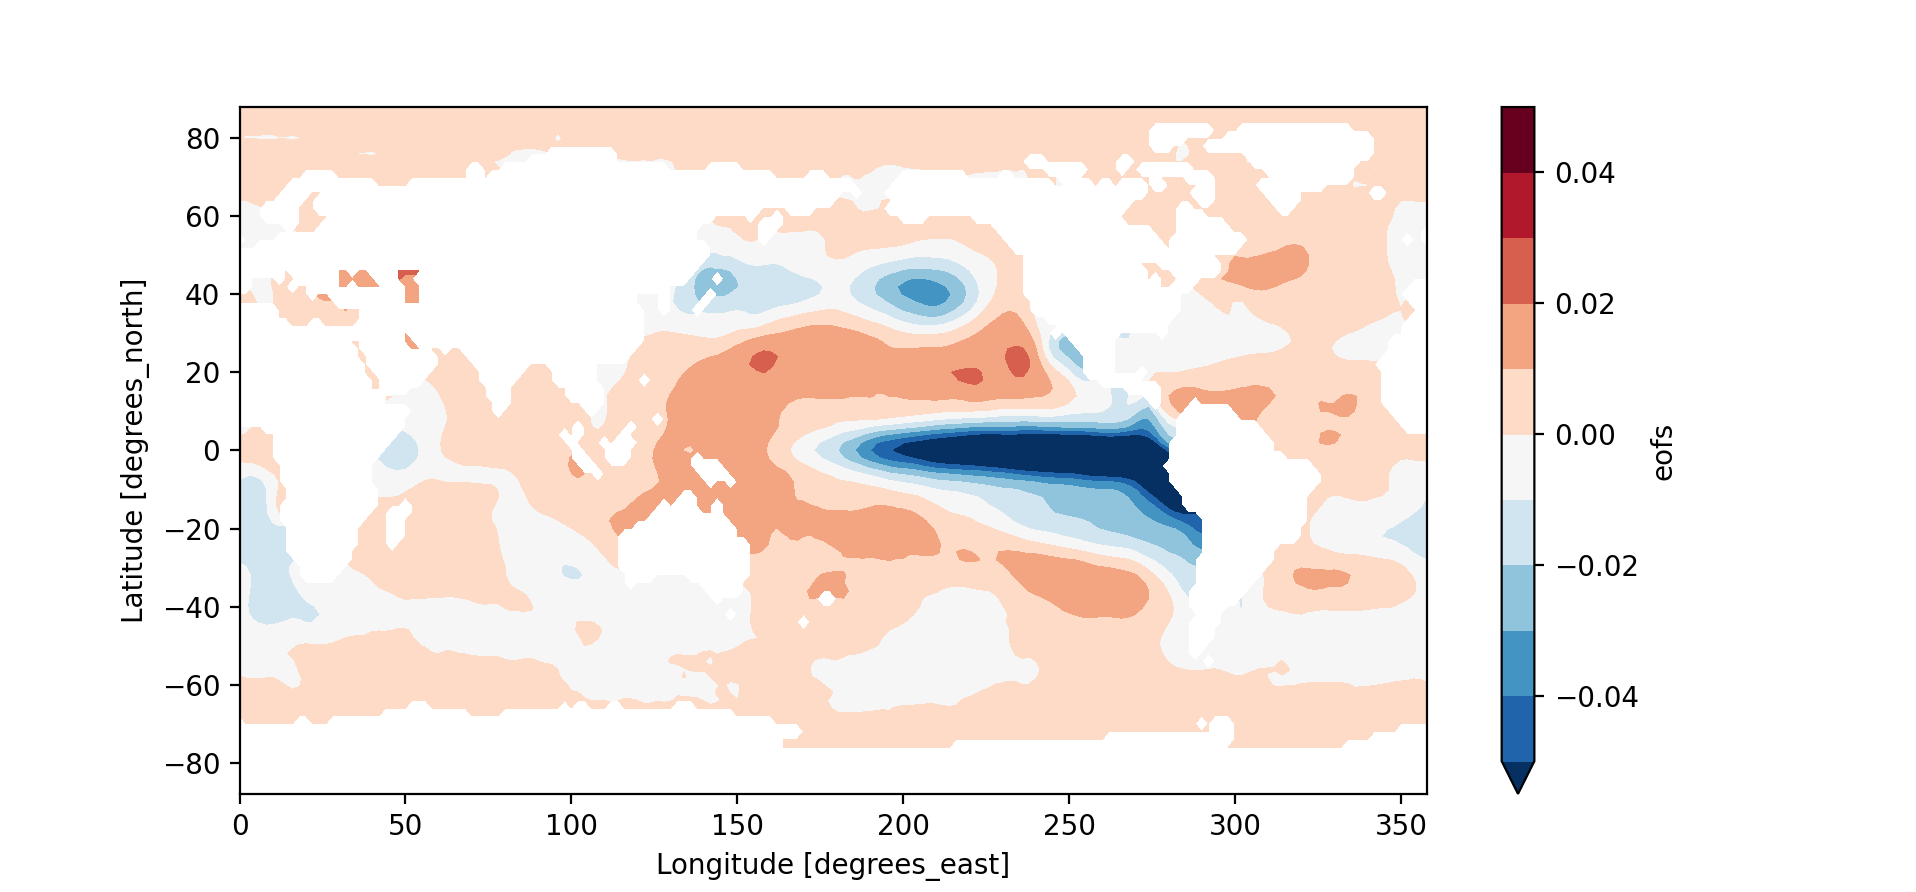

/Users/joymm/anaconda3/envs/research/lib/python3.6/site-packages/xarray/plot/utils.py:624: MatplotlibDeprecationWarning: The 'extend' parameter to Colorbar has no effect because it is overridden by the mappable; it is deprecated since 3.3 and will be removed two minor releases later.
  cbar = fig.colorbar(primitive, **cbar_kwargs)


In [38]:
%matplotlib notebook

# Get three EOFs from the solver
eofs = solver.eofs(neofs=3, )

# Plot the third one
(eofs[2, :]).plot.contourf(levels=12, robust=True)

## Obtain the variance fraction associated with each EOF

In [41]:
solver.varianceFraction(neigs=3)
# Here you see that the first EOF accounts for 15 percent of the variance, and the second and third account for
# 4.5 and 3.7 percent respectively

<xarray.DataArray 'variance_fractions' (mode: 3)>
array([0.15338039, 0.04596576, 0.03746454])
Coordinates:
  * mode     (mode) int64 0 1 2
Attributes:
    long_name:  variance_fractions

## Obtain the Principal Components corresponding to the EOFs

<IPython.core.display.Javascript object>


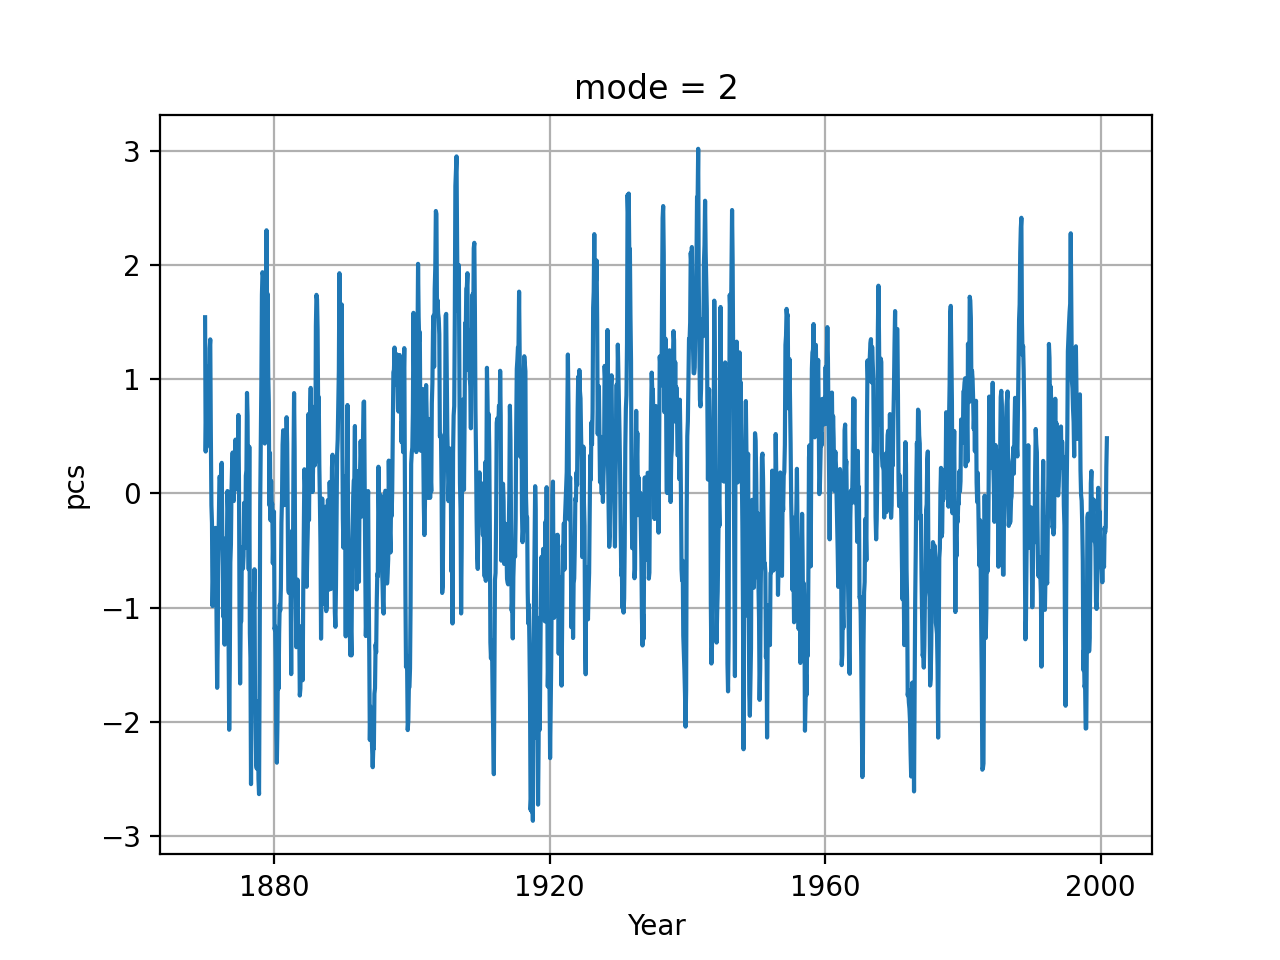

In [43]:
%matplotlib notebook

# pscaling scales the PCs to unit variance
pcs = solver.pcs(npcs=3, pcscaling=1)
(pcs[:, 2]).plot()
plt.xlabel('Year')
plt.grid()